In [26]:
[10, 20, 30, ]# # .!pip3 install numpy
# !pip3 install cirq
# !pip3 install qiskit
# !pip3 install mitiq

In [230]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import cirq
from mitiq import pec, Observable, PauliString

import numpy as np

from cirq import *

from mitiq import pec
from mitiq.pec.pec import *
from mitiq.pec.representations import *
from mitiq.pec import *
from mitiq.pec.representations.depolarizing import local_depolarizing_kraus
from mitiq.pec.channels import kraus_to_super
from mitiq.utils import _circuit_to_choi

In [231]:
import cirq
from mitiq import pec, benchmarks
from mitiq.benchmarks import random_circuits
import math

def execute(circuit: cirq.Circuit, noise_level: float = 0.001) -> float:
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real


circuit: cirq.Circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=10)[0]


representations_1 = representations.represent_operations_in_circuit_with_local_depolarizing_noise(circuit,
                noise_level=0.001,
)


print(f"{len(representations_1)} quasi-probability representations created.")
print("One for each gate of the input ideal circuit.\n")


8 quasi-probability representations created.
One for each gate of the input ideal circuit.



In [232]:
# import cirq
# from mitiq import pec, benchmarks
# from mitiq.benchmarks import random_circuits
# import math

# def execute(circuit: cirq.Circuit, noise_level: float = 0.001) -> float:
#     """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
#     noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
#     return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real


# circuit: cirq.Circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=50)[0]
    


true_value = execute(circuit, noise_level=0.0)       # Ideal quantum computer.
noisy_value = execute(circuit)                       # Noisy quantum computer.
pec_value = pec.execute_with_pec(circuit, execute, representations = representations_1)   # Noisy quantum computer + Mitiq.

print(f"Error (w/o  Mitiq): %0.4f" %abs((true_value - noisy_value) / true_value))
print(f"Error (with Mitiq): %0.4f" %abs((true_value - pec_value) / true_value))
print(circuit)

Error (w/o  Mitiq): 0.0158
Error (with Mitiq): 0.0037
0: ───Y───X───Y───X^-0.5───Y^-0.5───X^0.5───X───Y^-0.5───Y───X───Y^-0.5───X^0.5───Y^0.5───Y^0.5───X^0.5───Y^0.5───X^0.5───Y^-0.5───X^-0.5───Y^-0.5───Y^0.5───X^0───X^-0.5───Y^0───


In [9]:
# circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=50)[0]
# print(random_circuits.rand_circuit_pec(n_qubits=1, depthtrials=10, noise=0.01))

In [14]:
um_vals = []
pec_vals = []
from tqdm import tqdm
# num_cliffords = [10, 50]
num_cliffords = [10, 50, 100, 150 , 200]
for nc in tqdm(num_cliffords):
    circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=nc)[0]
    um_expval = execute(circuit)
    pec_expval = execute_with_pec(circuit, execute, representations = representations_1 )
    um_vals.append(um_expval)
    pec_vals.append(pec_expval)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [54:06<00:00, 649.32s/it]


In [119]:
num_samples

NameError: name 'num_samples' is not defined

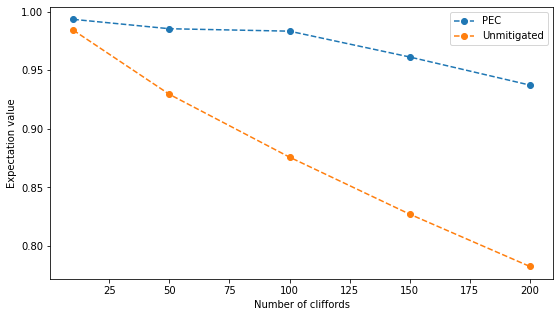

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

# average_zne_values = np.average(np.array(zne_values).reshape((len(nlayers_values), ntrials)), axis=1)
# average_noisy_values = np.average(np.array(noisy_values).reshape((len(nlayers_values), ntrials)), axis=1)

# plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

plt.plot(num_cliffords, pec_vals, "--o", label="PEC")
plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Number of cliffords")
plt.ylabel("Expectation value")

plt.legend()
# plt.savefig('Downloads/pec.png', dpi=300, facecolor='white')
plt.show();

In [233]:
from cirq import CZPowGate

phase = 5/16
CU = CZPowGate(exponent=phase*2)

from cirq.circuits import InsertStrategy
from cirq import H, SWAP, CZPowGate

def iqft(n,qubits,circuit):
    
    for i in range(n//2):
        circuit.append(SWAP(qubits[i],qubits[n-i-1]), strategy = InsertStrategy.NEW)
     
    #For each qubit
    for i in range(n-1,-1,-1):
        #Apply CR_k gates where j is the control and i is the target
        k=n-i #We start with k=n-i
        for j in range(n-1,i,-1):
            
            #CR_K gate
            crk = CZPowGate(exponent = -2/2**(k))
            circuit.append(crk(qubits[j],qubits[i]),strategy = InsertStrategy.NEW)
            k=k-1 
            
        #Apply Hadamard to the qubit
        circuit.append(H(qubits[i]),strategy = InsertStrategy.NEW)

        
def qpe(t,control, target, circuit, CU):
    
    #Apply Hadamard to control qubits
    circuit.append(cirq.H.on_each(control))
    
    #Apply CU gates
    for i in range(t):
        #Obtain the power of CU gate 
        CUi = CU**(2**i)
        #Apply CUi gate where t-i-1 is the control
        circuit.append(CUi(control[t-i-1],*target))
        
    #Apply inverse QFT
    iqft(t,control,circuit)
    
    
from cirq import X, SWAP, CZPowGate

#Create cirucit
qc = cirq.Circuit()

t=4 #Number of qubits in the control register
n=1 #Number of qubits in the register storing eigenvector

#Create t control qubits
control = [cirq.LineQubit(i) for i in range(t) ]

#Create n target qubits
target = [cirq.LineQubit(i) for i in range(t,t+n) ]

#Set target qubit to state |1> 
qc.append(X.on_each(target))

#Apply QPE
qpe(t,control, target, qc, CU)



ideal_circuit = qc
ideal_circuit


0: ───H───────────────────────────────@───×───────────────────────────────────────────────@──────────@─────────@────────H───
                                      │   │                                               │          │         │
1: ───H───────────────────────@───────┼───┼───×────────────────────@─────────@────────H───┼──────────┼─────────@^-0.5───────
                              │       │   │   │                    │         │            │          │
2: ───H─────────────@─────────┼───────┼───┼───×───────@────────H───┼─────────@^-0.5───────┼──────────@^-0.25────────────────
                    │         │       │   │           │            │                      │
3: ───H───@─────────┼─────────┼───────┼───×───────H───@^-0.5───────@^-0.25────────────────@^(-1/8)──────────────────────────
          │         │         │       │
4: ───X───@^(5/8)───@^-0.75───@^0.5───@─────────────────────────────────────────────────────────────────────────────────────

In [234]:
from mitiq import PauliString


paulis = []
paulis.append(PauliString("I", coeff=0.5*(2**t-1)))
for p in range(t):    
    paulis.append(PauliString("Z", coeff=0.5*-2**(t-1-p), support=(p,)))
obs = Observable(*paulis)
print(obs)

(7.5+0j)*I + (-4+0j)*Z(0) + (-2+0j)*Z(1) + -Z(2) + (-0.5+0j)*Z(3)


In [235]:
noise_level = 0.01

In [236]:
def noisy_execute(circuit: cirq.Circuit, noise_level: float = 0.001) -> float:
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real

def ideal_executor(circ: Circuit) -> float:
    return noisy_execute(circ, noise_level=0)

In [237]:
ideal_value = ideal_executor(ideal_circuit)
print(ideal_value)

unmitigated_expectation_value = noisy_execute(ideal_circuit)
print(unmitigated_expectation_value )

0.0
0.00087957614


In [238]:
from mitiq.pec.pec import *
from mitiq.pec.representations import *

representations = representations.represent_operations_in_circuit_with_local_depolarizing_noise(ideal_circuit,
                noise_level=0.01,
)


print(f"{len(representations)} quasi-probability representations created.")
print("One for each gate of the input ideal circuit.\n")

print(representations)
representations[1]

17 quasi-probability representations created.
One for each gate of the input ideal circuit.

[<mitiq.pec.types.types.OperationRepresentation object at 0x7fd17dcce940>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd182f18970>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd183703ac0>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd1803240d0>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd17d6c7550>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd182f0b7c0>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd1804566a0>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd17d85be80>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd18032c5b0>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd16b87b9a0>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd175583be0>, <mitiq.pec.types.types.OperationRepresentation object at 0x7fd17ef21b50>, <mitiq.pec.types.t

In [239]:
pec_value, pec_data = pec.execute_with_pec(
    circuit=ideal_circuit,
    executor=noisy_execute,
    representations=representations,
    precision=0.5,
    full_output=True,
    random_state = np.random.RandomState(7),
)

print("Mitigated resukt", round(pec_value,3))

Mitigated resukt 0.001


In [240]:
ideal_expectation_value = ideal_executor(ideal_circuit)

unmitigated_expectation_value = noisy_execute(ideal_circuit)

pec_value, pec_data = pec.execute_with_pec(
    circuit=ideal_circuit,
    executor=noisy_execute,
    representations=representations,
    precision = 0.38,
#     num_samples = 5000,
    full_output=True,
    random_state = np.random.RandomState(7),)

print(ideal_expectation_value)
print(unmitigated_expectation_value)
print(pec_value)

print("Error without PEC:", abs(ideal_expectation_value - unmitigated_expectation_value))
print("Error with PEC:", abs(ideal_expectation_value - pec_value))

0.0
0.00087957614
0.0007352995796952888
Error without PEC: 0.00087957614
Error with PEC: 0.0007352995796952888


In [241]:
import matplotlib.pyplot as plt

In [242]:
# from functools import partial
# from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp

# from mitiq import *
# from mitiq.interface import mitiq_cirq
# from mitiq.zne import RichardsonFactory
# from tqdm import tqdm

# # num_to_average = 25
# shots = 1000
# noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
# noise_levels = [0.0025, 0.005, 0.0075, 0.01]
# # scale_factors = [1.0, 3.0, 5.0, 7.0]
# results = {}

# for nm in noise_models:
#     exp_vals = []
# #     all_exp_values = {}
#     for noise_level in tqdm(noise_levels):
#         circuit = qc.copy()
#         execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)     
#         exp_val = execute_with_pec(circuit, execute_with_noise, obs, representations = representations).real
# #         all_exp_vals = factory.get_expectation_values()
# #         all_exp_values[noise_level] = np.real(all_exp_vals)
#         exp_vals.append(exp_val)
    
#     results[noise_level] = exp_vals

In [243]:
# results

In [291]:
from functools import partial
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp

from mitiq import *
from mitiq.interface import mitiq_cirq
from mitiq.zne import RichardsonFactory
from tqdm import tqdm


shots = 1
noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.01, 0.02, 0.03, 0.04,]
# scale_factors = [1.0, 3.0, 5.0, 7.0]
results = {}

for nm in noise_models:
    exp_vals = []
#     all_exp_values = {}
    for noise_level in tqdm(noise_levels):
        circuit = qc.copy()
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=
                                     shots)     
        exp_val = execute_with_pec(circuit, execute_with_noise, obs, representations = representations, precision=0.38).real
#         all_exp_vals = factory.get_expectation_values()
#         all_exp_values[noise_level] = np.real(all_exp_vals)
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]


In [292]:
exp_vals= [exp_vals]
exp_val

4.176546602384321

In [293]:
results

{'depolarize': [3.505315898429698,
  7.010631796859396,
  6.786888228874521,
  4.624033738354069],
 'phase_flip': [2.535760437161909,
  7.308956554172561,
  10.143041748647635,
  7.159794175515978],
 'bit_flip': [7.6818625008140184,
  2.237435679848743,
  9.546392234021303,
  3.281572330444824],
 'phase_damp': [3.803640655742863,
  5.9664951462633145,
  4.698614927682361,
  5.519008010293566],
 'amplitude_damp': [3.5053158984296973,
  4.773196117010652,
  7.3835377435008525,
  4.176546602384321]}

In [294]:
noise_levels

[0.01, 0.02, 0.03, 0.04]

In [295]:
import matplotlib.pyplot as plt


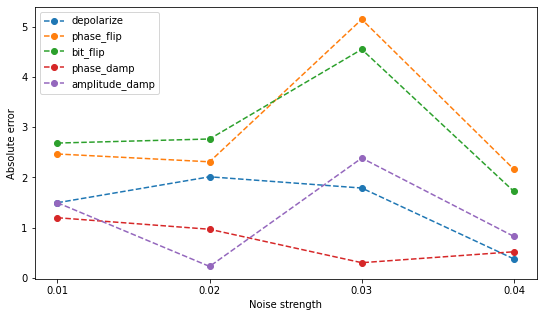

In [296]:
exact = 5
plt.figure(figsize=(9, 5))
for nm, exp_vals in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

plt.xlabel("Noise strength")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models.png', dpi=300, facecolor='white')
plt.show();